In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from deem import deem
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches

In [25]:
param_grid = {'LR_param': {'C':[10**k for k in range(-10, 6, 2)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

## performance drop

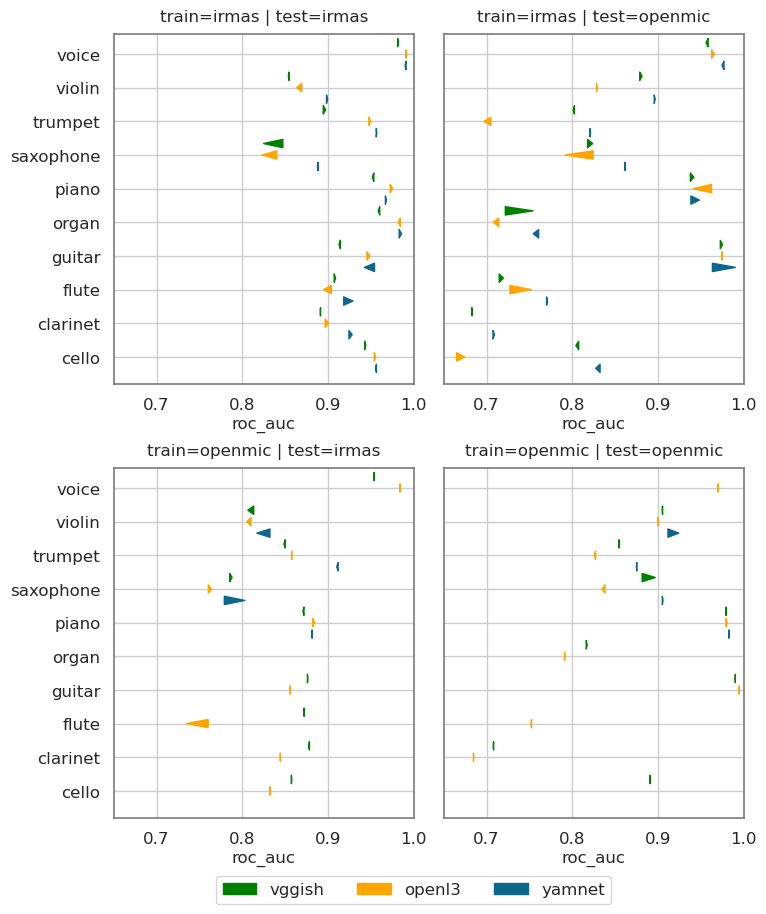

In [26]:
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 20 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(instrument_map)) * 5 + 1.7,
                   'openl3': np.arange(len(instrument_map)) * 5,
                   'yamnet': np.arange(len(instrument_map)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

#         y = y - dist
#         x = list(df[df['embedding']==bias_lir_nonlir[2]][metric])
# #         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
#         for mark in range(len(y)):
#             ax.annotate('', (x[mark], y[mark]), 
#                     xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
#                         arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title('train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all_lda.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(6,7))

size = 12
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'openmic'; test_set = 'irmas'
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])

# Creating legend with color box
patch1 = mpatches.Patch(color='green', label='vggish')
patch2 = mpatches.Patch(color='orange', label='openl3')
patch3 = mpatches.Patch(color='#0e668b', label='yamnet')
plt.legend(handles=[patch1, patch2, patch3], loc="lower center", ncol=3, bbox_to_anchor=(1, -0.27))
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
# plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/irmas_only_lda.pdf', bbox_inches = "tight")

## original performance

In [27]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['test_set']==test_set]
    df = df_visual1[df_visual1['train_set']==train_set]

    dist = .3
    y = np.arange(len(instrument_map)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')

In [28]:
result_all = pd.read_csv('results/result_all_lda.csv')
result_all['debias_method'] = [list(result_all['embedding'])[k].replace(list(result_all['embedding'])[k].split('-')[0], '') \
                               for k in range(len(result_all['embedding']))]
result_all['embedding'] = [list(result_all['embedding'])[k].split('-')[0] \
                               for k in range(len(result_all['embedding']))]
result_all['debias_method'] = ['original' if k=='' else k for k in result_all['debias_method']] 

df = result_all[result_all['debias_method']=='original']
df = df.reset_index(drop=True)

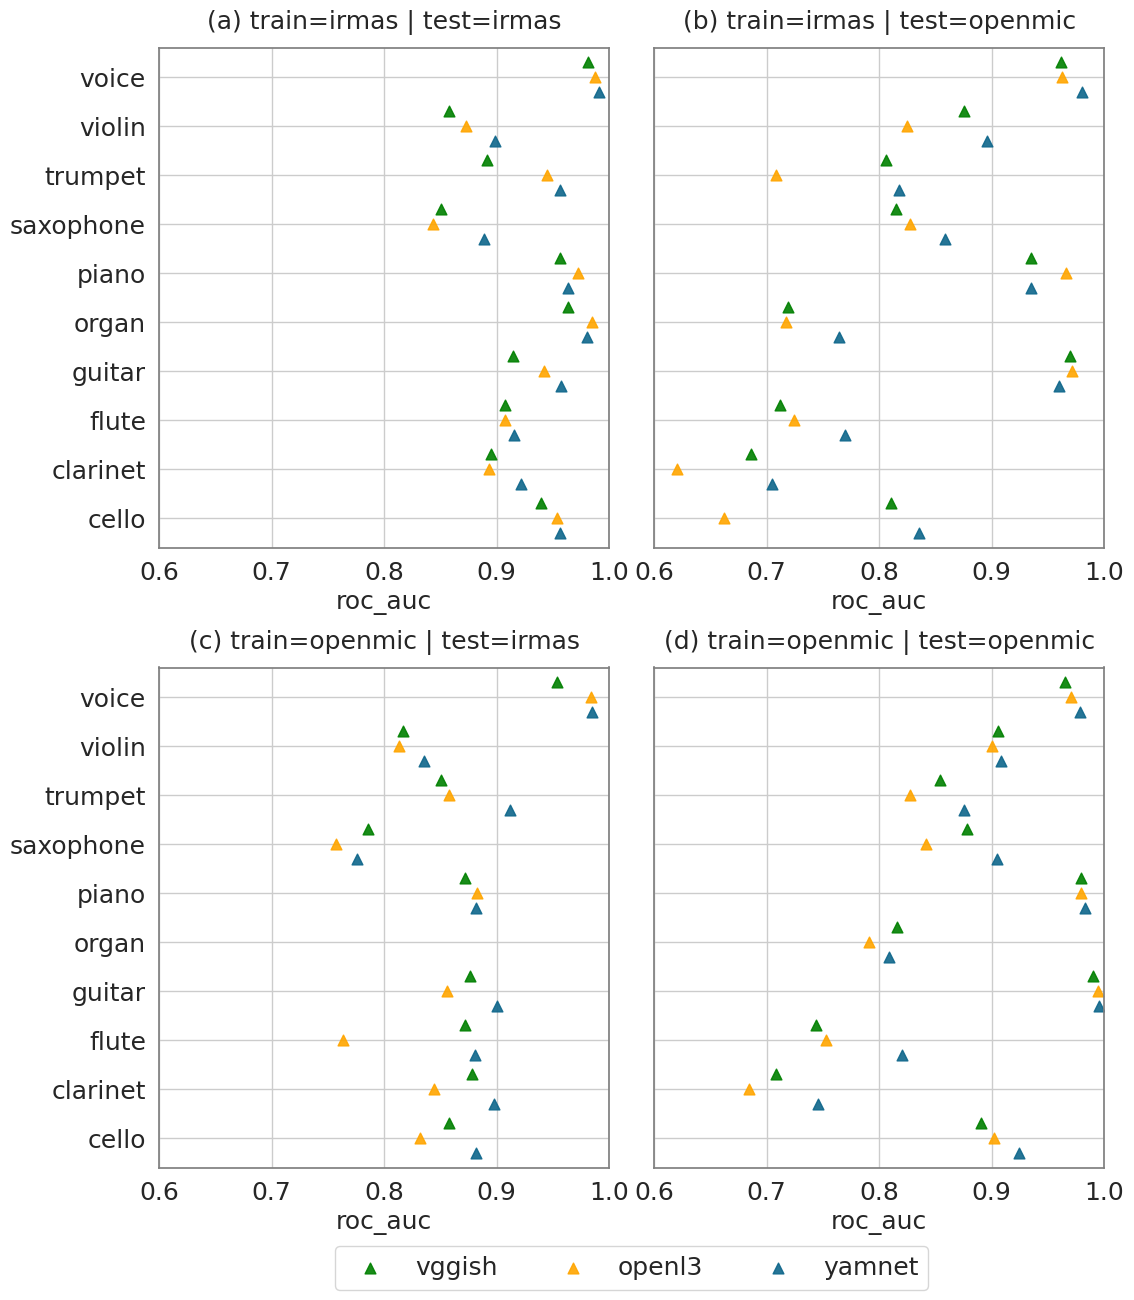

In [30]:
metric = 'roc_auc'
figure = plt.figure(figsize=(9,10))

size = 18
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

   

train_set = 'openmic'; test_set = 'irmas'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])


train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-3,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.27)) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'irmas'; test_set = 'openmic'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48]); ax.set_yticklabels([]);

plt.tight_layout(); 
plt.savefig('results/original_performance.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

## statistics

In [31]:
df = pd.read_csv('results/result_all_lda.csv')

In [32]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-lda', 'openl3-lda', 'yamnet-lda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['irmas', 'irmas'], ['openmic', 'openmic'], ['openmic', 'irmas'], ['irmas', 'openmic']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))

In [33]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.915701,NaN
0,vggish,openmic,openmic,0.873194,NaN
0,vggish,openmic,irmas,0.830491,NaN
0,vggish,irmas,openmic,0.828863,NaN
0,openl3,irmas,irmas,0.93021,NaN
0,openl3,openmic,openmic,0.864303,NaN
0,openl3,openmic,irmas,0.801448,NaN
0,openl3,irmas,openmic,0.798426,NaN
0,yamnet,irmas,irmas,0.942799,NaN
0,yamnet,openmic,openmic,0.894543,NaN


In [34]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [35]:
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [36]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.915701,NaN
0,vggish,openmic,openmic,0.873194,NaN
0,vggish,openmic,irmas,0.830491,-0.08521
0,vggish,irmas,openmic,0.828863,-0.044331
0,openl3,irmas,irmas,0.93021,NaN
0,openl3,openmic,openmic,0.864303,NaN
0,openl3,openmic,irmas,0.801448,-0.128762
0,openl3,irmas,openmic,0.798426,-0.065877
0,yamnet,irmas,irmas,0.942799,NaN
0,yamnet,openmic,openmic,0.894543,NaN


In [37]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9157006044995522, 0.8731936771069033, 0.8304907249256074, 0.8288625581655555], change: [nan, nan, -0.08520987957394477, -0.04433111894134778]
openl3, mean: [0.9302104169203093, 0.8643028609078357, 0.8014483670635197, 0.7984263156927883], change: [nan, nan, -0.12876204985678952, -0.06587654521504738]
yamnet, mean: [0.9427988081187489, 0.8945432204953573, 0.8494569100809939, 0.8521111669185097], change: [nan, nan, -0.09334189803775506, -0.04243205357684754]


In [38]:
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish-lda, mean: [0.9122237715405397, 0.8755303902785572, 0.8304663349296997, 0.8353498334061665], change: [nan, nan, -2.4389995907703188e-05, 0.00648727524061099]
openl3-lda, mean: [0.9281813062349574, 0.8632314680535386, 0.7984858951844849, 0.7927589869438088], change: [nan, nan, -0.002962471879034867, -0.005667328748979572]
yamnet-lda, mean: [0.9449916905019335, 0.8965149185540027, 0.8531884974256707, 0.8565585896280175], change: [nan, nan, 0.0037315873446768233, 0.004447422709507709]


(0.4, 1.0)

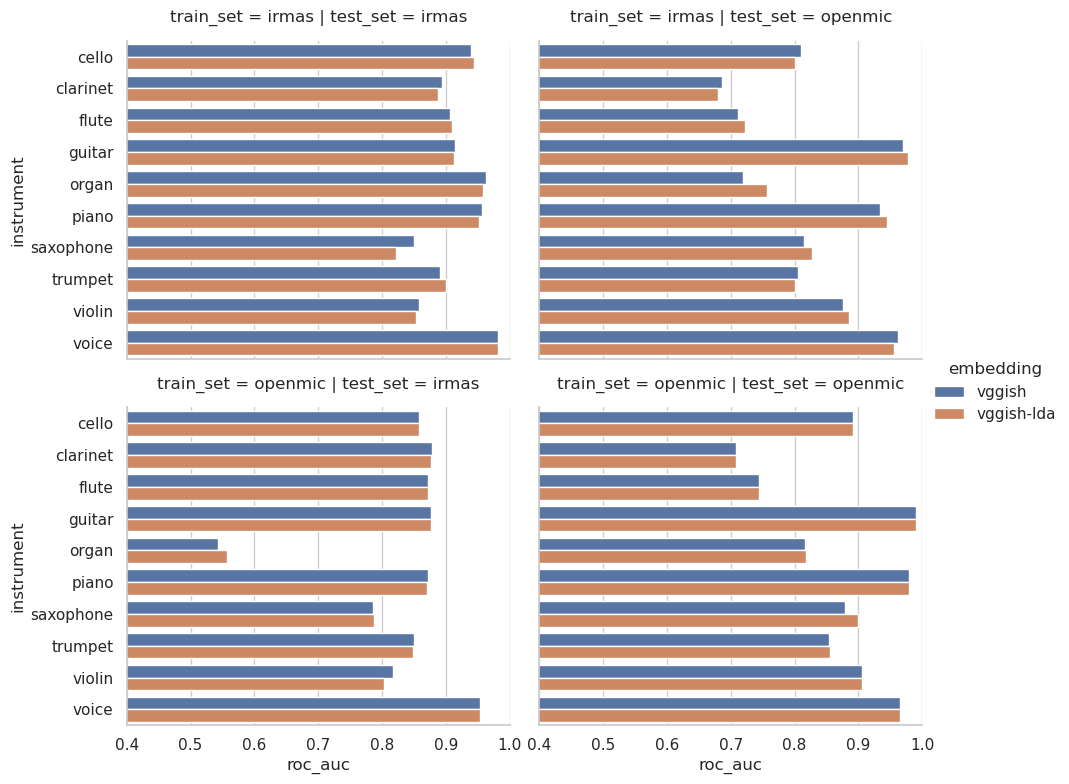

In [21]:
# save all result into a csv file
df = pd.read_csv('results/result_vggish-lda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')

(0.4, 1.0)

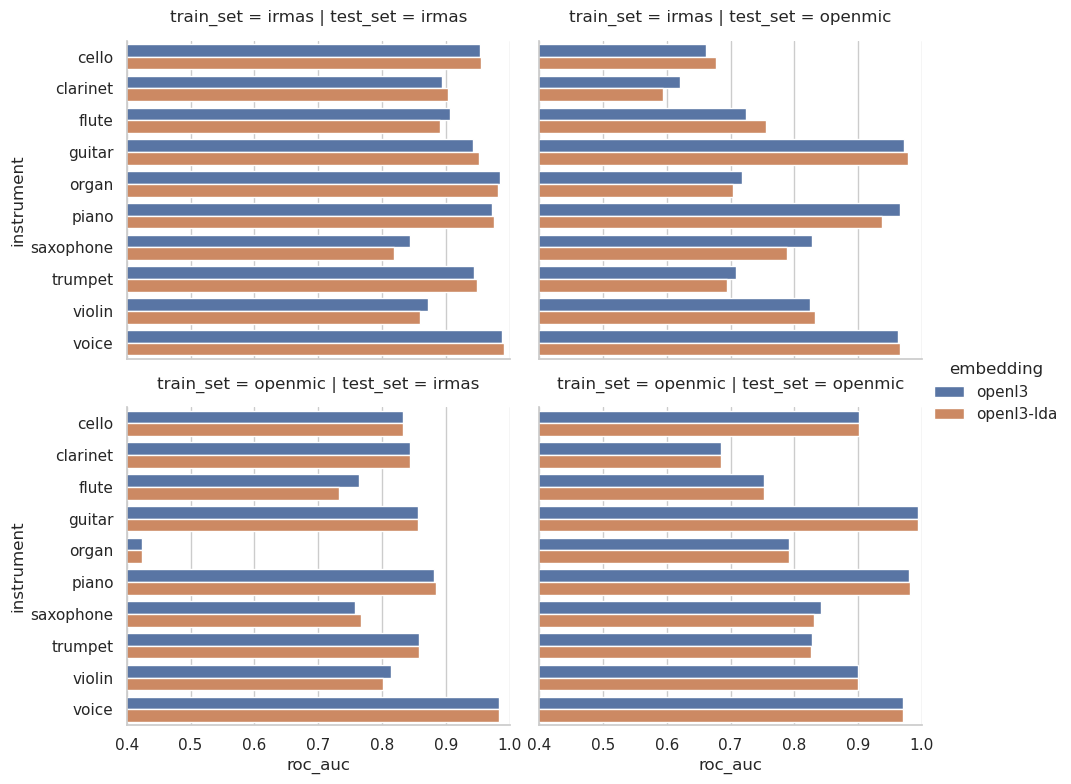

In [22]:
# save all result into a csv file
embedding = 'openl3'
debias_method = '-lda'
df = pd.read_csv('results/result_' + embedding + debias_method + '.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')

(0.4, 1.0)

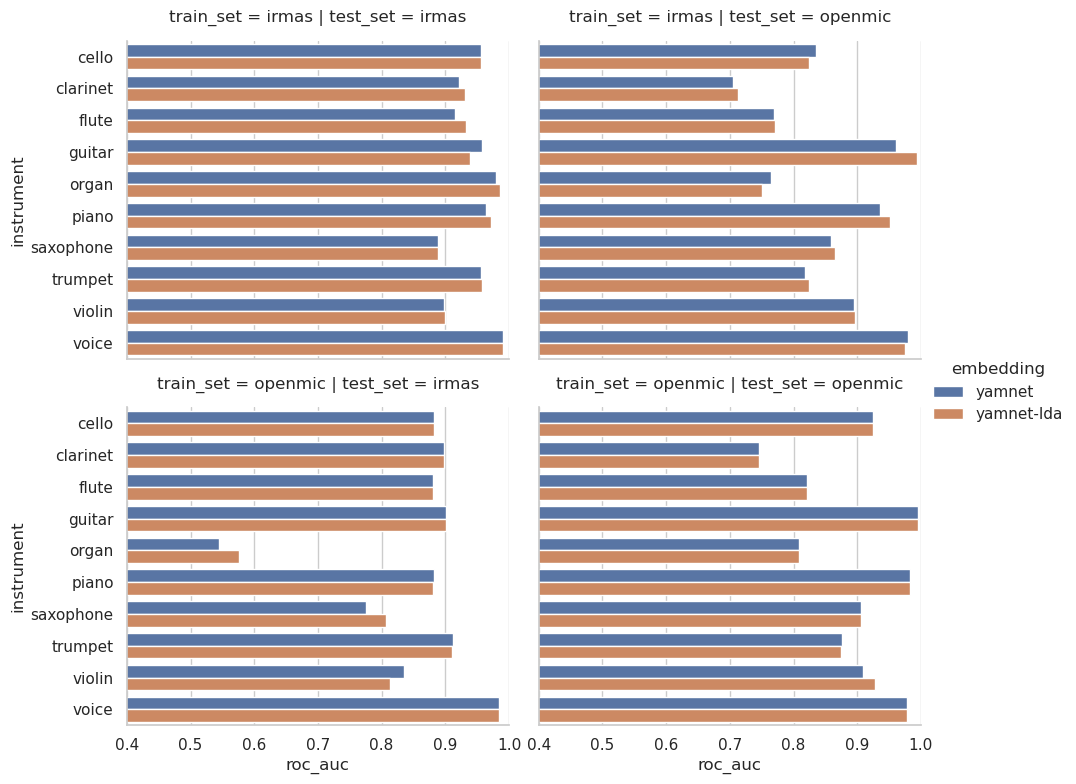

In [23]:
# save all result into a csv file
embedding = 'yamnet'
debias_method = '-lda'
df = pd.read_csv('results/result_' + embedding + debias_method + '.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')